# High Resolution X-Ray Diffraction with Rigaku SmartLab

Written by Josef Stevanus (Aalto University, Espoo), modified from alignment routine by Dr. Carsten Richter (IKZ, Berlin)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import xrayutilities as xu

from scipy.interpolate import UnivariateSpline
from scipy.optimize import brentq

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
from rigaku_smartlab.dataset import *

## Functions to Plot Data

In [4]:
def plot_Z_scan_with_edge(df, custom_formatter=custom_formatter, label_size=20, fig_size=(6.4, 4.8)):
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    ax.plot(df['Z'], df['int'], label='Z scan')

    # Find half maximum intensity
    max_int = df['int'].max()
    half_max = max_int / 2

    # Spline interpolation for finer Z resolution

    # Sort by Z to ensure monotonicity
    df_sorted = df.sort_values('Z')
    Z_fine = np.arange(df_sorted['Z'].min(), df_sorted['Z'].max(), 0.0001)
    spline = UnivariateSpline(df_sorted['Z'], df_sorted['int'] - half_max, s=0)
    int_fine = spline(Z_fine)

    # Find the Z position where the spline crosses zero (half max)

    # Find all sign changes
    sign_changes = np.where(np.diff(np.sign(int_fine)))[0]
    if len(sign_changes) > 0:
        # Take the first crossing (or choose as needed)
        i_cross = sign_changes[0]
        Z_half = brentq(spline, Z_fine[i_cross], Z_fine[i_cross + 1])
        int_half = half_max
    else:
        # Fallback to closest value in original data
        idx_half = (df['int'] - half_max).abs().idxmin()
        Z_half = df.loc[idx_half, 'Z']
        int_half = df.loc[idx_half, 'int']

    # Plot the half max line and marker
    ax.axhline(half_max, color='red', linestyle='--', label='Half max')
    ax.axvline(Z_half, color='green', linestyle='--', label=f'Edge (Z={Z_half:.2f})')
    ax.plot(Z_half, int_half, 'ro')

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    if custom_formatter:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
    ax.tick_params(axis='both', which='major', labelsize=label_size)
    ax.tick_params(axis='both', which='minor', labelsize=label_size - 2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    ax.set_xlabel('Z position (mm)', fontsize=label_size)
    ax.set_xlim(df['Z'].min(), df['Z'].max())
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Intensity (a.u.)', fontsize=label_size)

    fig.tight_layout()
    fig.show()

    return Z_half

def plot_scan(df, custom_formatter=custom_formatter,
              xlim = None, label_size=20, fig_size=(6.4, 4.8)):
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    ax.plot(df.iloc[:, 0], df.iloc[:, 1])

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    if custom_formatter:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
    ax.tick_params(axis='both', which='major', labelsize=label_size)
    ax.tick_params(axis='both', which='minor', labelsize=label_size - 2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    if xlim is None:
        ax.set_xlim(-df.iloc[:,0].max(), df.iloc[:,0].max())
    else:
        ax.set_xlim(xlim)
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Intensity (a.u.)', fontsize=label_size)

    # Set xlabel based on the first column name, format to LaTeX if 'omega' or 'chi'
    colname = df.columns[0]
    if colname == 'Omega':
        ax.set_xlabel(r'$\mathrm{\omega}$ ($\degree$)', fontsize=label_size)
    elif colname == 'Chi':
        ax.set_xlabel(r'$\mathrm{\chi}$ ($\degree$)', fontsize=label_size)
    elif colname == 'TwoTheta':
        ax.set_xlabel(r'$\mathrm{2\theta}$ ($\degree$)', fontsize=label_size)        
    else:
        ax.set_xlabel(colname, fontsize=label_size)

    if xlim is None:
        ax.set_xlim(-df.iloc[:,0].max(), df.iloc[:,0].max())
    else:
        ax.set_xlim(xlim)
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Intensity (a.u.)', fontsize=label_size)

    fig.tight_layout()
    fig.show()

def plot_multi_scan(dfs, labels=None, custom_formatter=custom_formatter, 
                    xlim=None, label_size=20, fig_size=(6.4, 4.8), last_mode = False):
    """
    Plot multiple scans on the same axes.

    Parameters:
        dfs (list): List of pandas DataFrames to plot.
        labels (list): List of labels for each scan.
        custom_formatter (callable): Optional y-axis formatter.
        xlim (tuple): Optional x-axis limits.
        label_size (int): Font size for labels.
        fig_size (tuple): Figure size.
    """

    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    for i, df in enumerate(dfs):
        label = labels[i] if labels is not None else None
        ax.plot(df.iloc[:, 0], df.iloc[:, 1], label=label)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    if custom_formatter:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
    ax.tick_params(axis='both', which='major', labelsize=label_size)
    ax.tick_params(axis='both', which='minor', labelsize=label_size - 2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    colname = dfs[0].columns[0]
    if colname.lower() == 'omega':
        ax.set_xlabel(r'$\mathrm{\omega}$ ($\degree$)', fontsize=label_size)
    elif colname.lower() == 'chi':
        ax.set_xlabel(r'$\mathrm{\chi}$ ($\degree$)', fontsize=label_size)
    else:
        ax.set_xlabel(colname, fontsize=label_size)

    if xlim is None:
        all_x = pd.concat([df.iloc[:, 0] for df in dfs])
        ax.set_xlim(all_x.min(), all_x.max())
    else:
        ax.set_xlim(xlim)
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Intensity (a.u.)', fontsize=label_size)

    if labels is not None:
        ax.legend(fontsize=label_size - 2)

    fig.tight_layout()
    fig.show()

def reciprocal_space_map_1D(list_files, use_rlu, xlim = None, ylim = None, 
    grid_size = 512, dyn_low = 4, dyn_high = 0, levels = 15, label_size = 20, 
    title = 'Reciprocal Space Map (1D)'):
    """
    Function to create a 1D RSM from a list of files

    Parameters
    ----------
    list_files : list
        List of files to be processed
    use_rlu : bool
        If True, use RLU coordinates
    xlim: tuple (optional)
        X-axis limits for the plot (RLU coordinates)
    ylim: tuple (optional)
        Y-axis limits for the plot (RLU coordinates)
    grid_size : int
        Size of the grid for the reciprocal space map, default is 512
    dyn_low : int
        Lower dynamic range limit for the color map, default is 4
    dyn_high : int
        Upper dynamic range limit for the color map, default is 0
    levels : int (optional)
        Number of levels for the contour plot, default is 15
    label_size : int
        Size of the labels in the plot
    title : str
        Title of the plot, default is 'Reciprocal Space Map (1D)'
    """    

    # Read the data from list of files
    [omega, two_theta], data = xu.io.getras_scan(
        list_files, None, 'Omega', 'TwoTheta',
    )

    # Get the 2D grid based on unique values of omega and two theta
    grid_angular = xu.Gridder2D(len(np.unique(omega)), len(np.unique(two_theta)))
    grid_angular(omega, two_theta, data['int'])

    # Plot initialization
    plt.figure(figsize=(7.5, 8), dpi=600)   

    if use_rlu:
        # Define the Q vectors for the Si material and initialize the HR-XRD object
        Si = xu.materials.Si
        hxrd = xu.HXRD(
            Si.Q(1, 1, -2), Si.Q(1, 1, 1), wl = xu.config.WAVELENGTH,
        )

        # Initialize the Gridder2D object for RLU coordinates
        grid_reciprocal = xu.Gridder2D(grid_size, grid_size)

        # Get the Qy and Qz values for the reciprocal space map
        [_, Qy, Qz] = hxrd.Ang2Q(omega, two_theta)

        # Fill the grid with the intensity data
        grid_reciprocal(Qy, Qz, data['int'])

        # Set the limits for the color map       
        intensity_reciprocal = xu.maplog(
            grid_reciprocal.data.transpose(), dyn_low, dyn_high
        )

        # Plot the reciprocal space map (in RLU coordinates)
        cf = plt.contour(
            grid_reciprocal.xaxis / (2 * np.pi) * 10, 
            grid_reciprocal.yaxis / (2 * np.pi) * 10, 
            intensity_reciprocal, levels = levels, 
            cmap = 'jet', extend='min'
        )

        # Set axis labels
        plt.xlabel(r'$\mathrm{Q_{y}/(2\pi)}$ (nm)', fontsize=label_size)
        plt.ylabel(r'$\mathrm{Q_{z}/(2\pi)}$ (nm)', fontsize=label_size)
        plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    else:
        # Set the limits for the color map
        intensity = xu.maplog(
            grid_angular.data.transpose(), dyn_low, dyn_high
        )

        # Plot the reciprocal space map (in angular coordinates)
        cf = plt.contour(
            grid_angular.xaxis, 
            grid_angular.yaxis, 
            intensity, levels = levels,
            cmap='jet', extend='min'
        )

        # Set axis labels
        plt.xlabel(r'$\mathrm{\omega (\degree)}$', fontsize = label_size)
        plt.ylabel(r'2$\mathrm{\theta (\degree)}$', fontsize = label_size)
        plt.title('Reciprocal Space Map', fontsize = label_size)

    # Set colorbar
    cb = plt.colorbar(cf)
    cb.set_label(r'$\mathrm{\log(int) (cps)}$', fontsize = label_size)
    cb.ax.tick_params(labelsize=label_size - 2)

    # Set axis properties    
    ax = plt.gca()

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))
    ax.tick_params(axis = 'both', which = 'major', labelsize = label_size)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = label_size - 2)

    # Thicken only x and y-axis lines and remove the rest of the border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    if use_rlu:
        ax.set_xlim(xlim if xlim is not None else (-0.08, 0.08))
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(grid_angular.yaxis.min() / 2, 
                    grid_angular.yaxis.max() / 2)

    plt.title(title, fontsize=label_size)
    plt.tight_layout()

In [5]:
path_to_files = '../data/raw/NewSiCRoutine/'

## Sample alignment routine

Starts with a Z-scan, followed by an omega scan. This is a standard sample alignment.

Z=-0.6251 mm
Z=-0.6083 mm
Z=-0.6077 mm


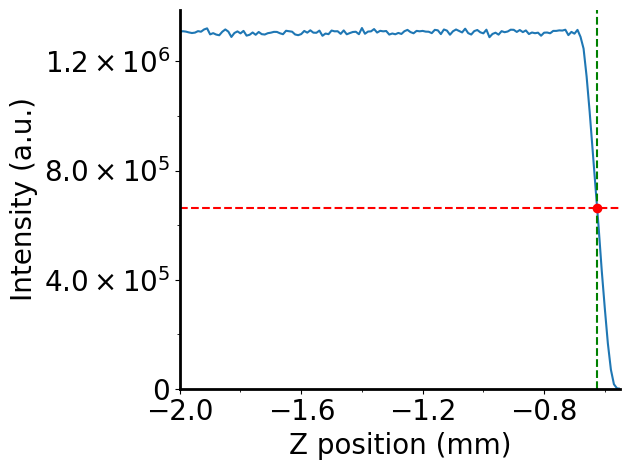

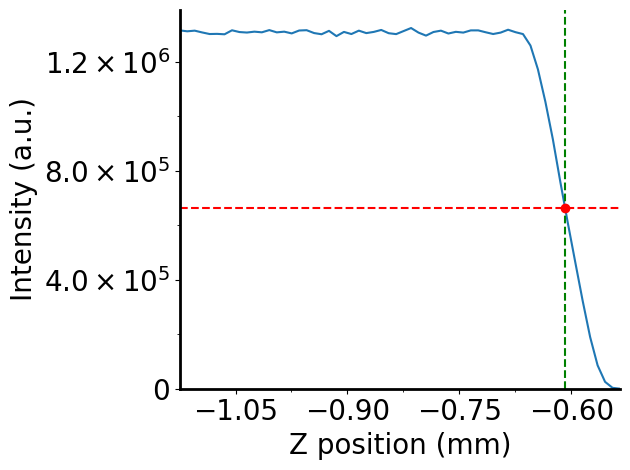

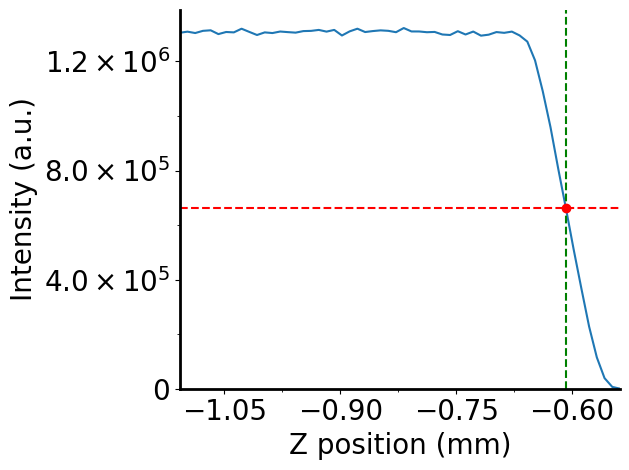

In [6]:
Z_scan_data = xu.io.rigaku_ras.RASFile(
    path_to_files + 'SiC_Z_scan.ras'
)

list_df_Z = []

for scan in Z_scan_data.scans:
    list_df_Z.append(pd.DataFrame(scan.data))
    
list_Z = []
for df in list_df_Z:
    Z = plot_Z_scan_with_edge(df)
    print(f"{Z=:.4f} mm")
    list_Z.append(Z)

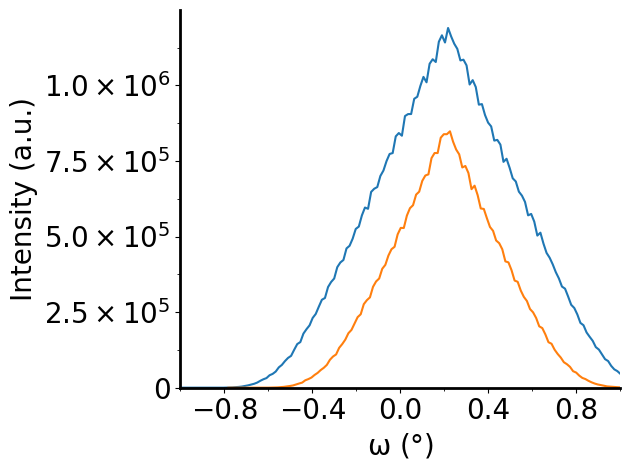

In [7]:
omega_scan_data = xu.io.rigaku_ras.RASFile(
    path_to_files + 'SiC_Omega_scan.ras'
)

list_df_Omega = []

for scan in omega_scan_data.scans:
    list_df_Omega.append(pd.DataFrame(scan.data))
    
plot_multi_scan(
    list_df_Omega, xlim = (-1, 1)
)

This can be extended with by a low angle ($2\theta$ = 0.5) to align the omega and chi.

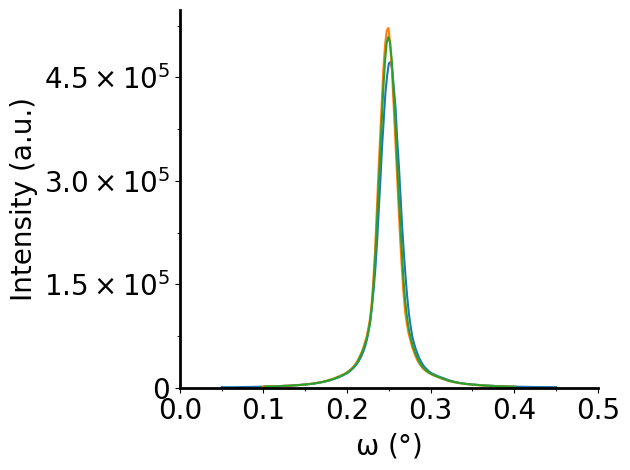

In [8]:
omega_chi_scan_data = xu.io.rigaku_ras.RASFile(
    '../data/raw/NewSiCRoutine/SiC_OmegaChi_scan.ras'
)

list_df_OmegaChi = []

for scan in omega_chi_scan_data.scans:
    list_df_OmegaChi.append(pd.DataFrame(scan.data))
    
plot_multi_scan(
    list_df_OmegaChi, xlim = (0., 0.5)
)

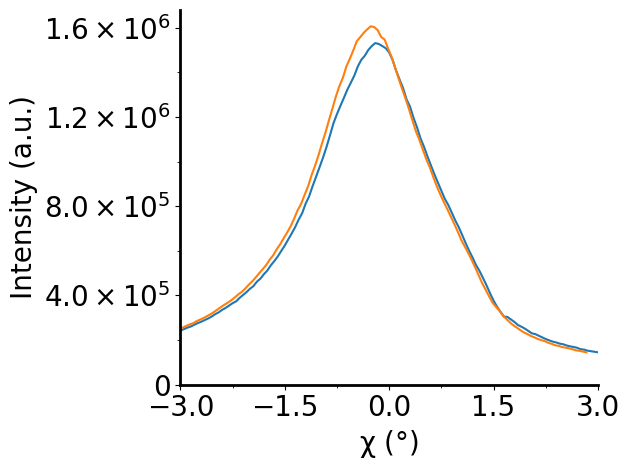

In [9]:
chi_scan_data = xu.io.rigaku_ras.RASFile(
    '../data/raw/NewSiCRoutine/SiC_Chi_scan.ras'
)

list_df_Chi = []

for scan in chi_scan_data.scans:
    list_df_Chi.append(pd.DataFrame(scan.data))
    
plot_multi_scan(
    list_df_Chi, xlim = (-3.0, 3.0)
)

## SiC 0004 alignment

Starts with an omega scan at $\varphi = 0\degree$ and $\varphi = 180\degree$, omega scan needs to be larger than the expected miscut, in this case -5 to 5 degree is used. From the two peaks, we select the mid point

$$\omega = \frac{\omega_{\varphi = 0\degree} + \omega_{\varphi = 180\degree}}{2}$$

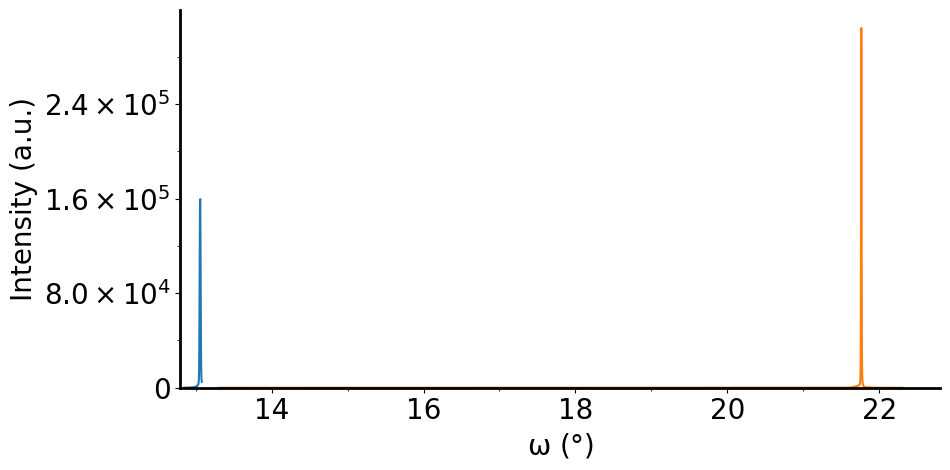

In [10]:
sic_omega_scan_data = xu.io.rigaku_ras.RASFile(
    path_to_files + 'SiC0004_Omega_scan.ras'
)

list_df_SiC_Omega = []

for scan in sic_omega_scan_data.scans:
    list_df_SiC_Omega.append(pd.DataFrame(scan.data))
    
plot_multi_scan(
    list_df_SiC_Omega, 
    xlim = (35.6/2 - 5, 35.6/2 + 5),
    fig_size = (9.6, 4.8)
)

This is then followed by a Ry scan ($\varphi = 0\degree$) and Rx scan ($\varphi = 90\degree$)

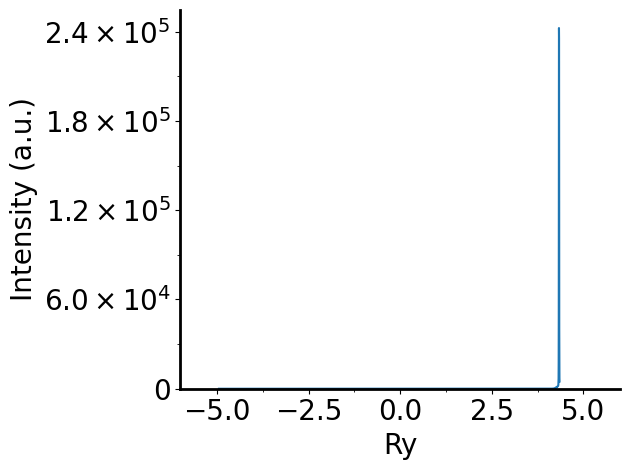

In [11]:
sic_ry_scan_data = xu.io.rigaku_ras.RASFile(
    path_to_files + 'SiC0004_Ry_scan.ras'
)

df_Ry = pd.DataFrame(sic_ry_scan_data.scan.data)
plot_scan(df_Ry, xlim = (-6, 6))

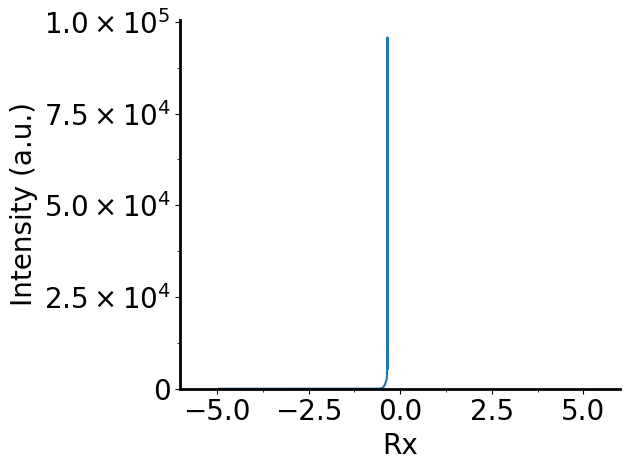

In [12]:
sic_rx_scan_data = xu.io.rigaku_ras.RASFile(
    path_to_files + 'SiC0004_Rx_scan.ras'
)

df_Rx = pd.DataFrame(sic_rx_scan_data.scan.data)
plot_scan(df_Rx, xlim = (-6, 6))

Followed by the rocking curve pre-alignment routine, omega and chi scan. This one failed for some reason, but shows how it looks like, finding the peak omega and chi

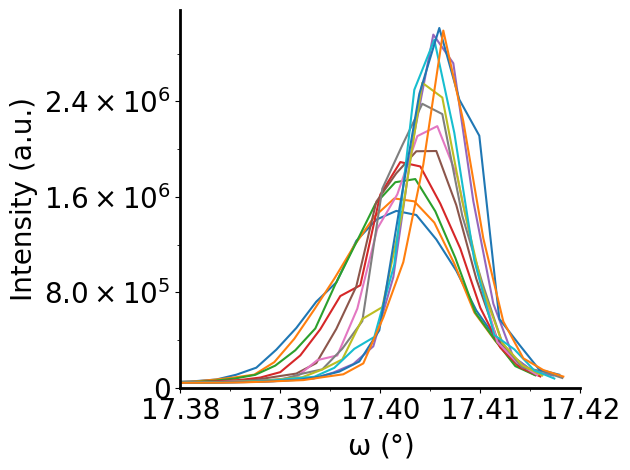

In [13]:
sic_rec_omega_scan_data = xu.io.rigaku_ras.RASFile(
    path_to_files + 'SiC0004_RecursiveOmega_scan.ras'
)

list_df_SiC_RecOmega = []

for scan in sic_rec_omega_scan_data.scans:
    list_df_SiC_RecOmega.append(
        pd.DataFrame(scan.data)
    )
    
plot_multi_scan(
    list_df_SiC_RecOmega, 
    xlim = (17.38, 17.42),
)

When the right alignment has been made, we should get a good sharp peak, important for a rocking curve:

Rx: -0.3485, Ry: 4.3349
Offset Angle: 4.3489, Azimuth Angle: 94.6004
Omega: 17.79, Two Theta: 35.58, Beta: 0.01


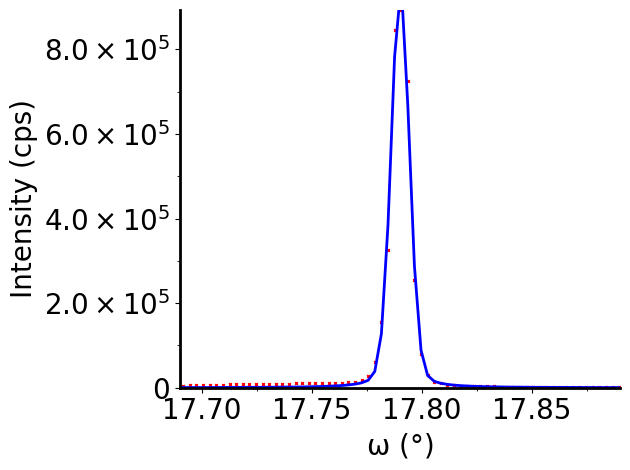

In [14]:
sic_0004_fit = pseudo_voigt(
    '../data/raw/20250528_M3-1146_SiC_0004.ras',
    normalized = False, verbose = True, plot = True,
    xlim = (35.58 / 2 - 0.1, 35.58 / 2 + 0.1)
)

In [15]:
sic0004_fwhm = sic_0004_fit.params['fwhm'].value * 3600
stderr_sic0004_fwhm = sic_0004_fit.params['fwhm'].stderr * 3600
print(f"SiC (0004) FWHM = {sic0004_fwhm:.1f}" +
      f" \u00B1 {stderr_sic0004_fwhm:.1f}" +
      " arcsec")

SiC (0004) FWHM = 34.6 ± 0.3 arcsec


## Reciprocal Space Map

Since the alignment was not successful, the RSM we received was still poor.

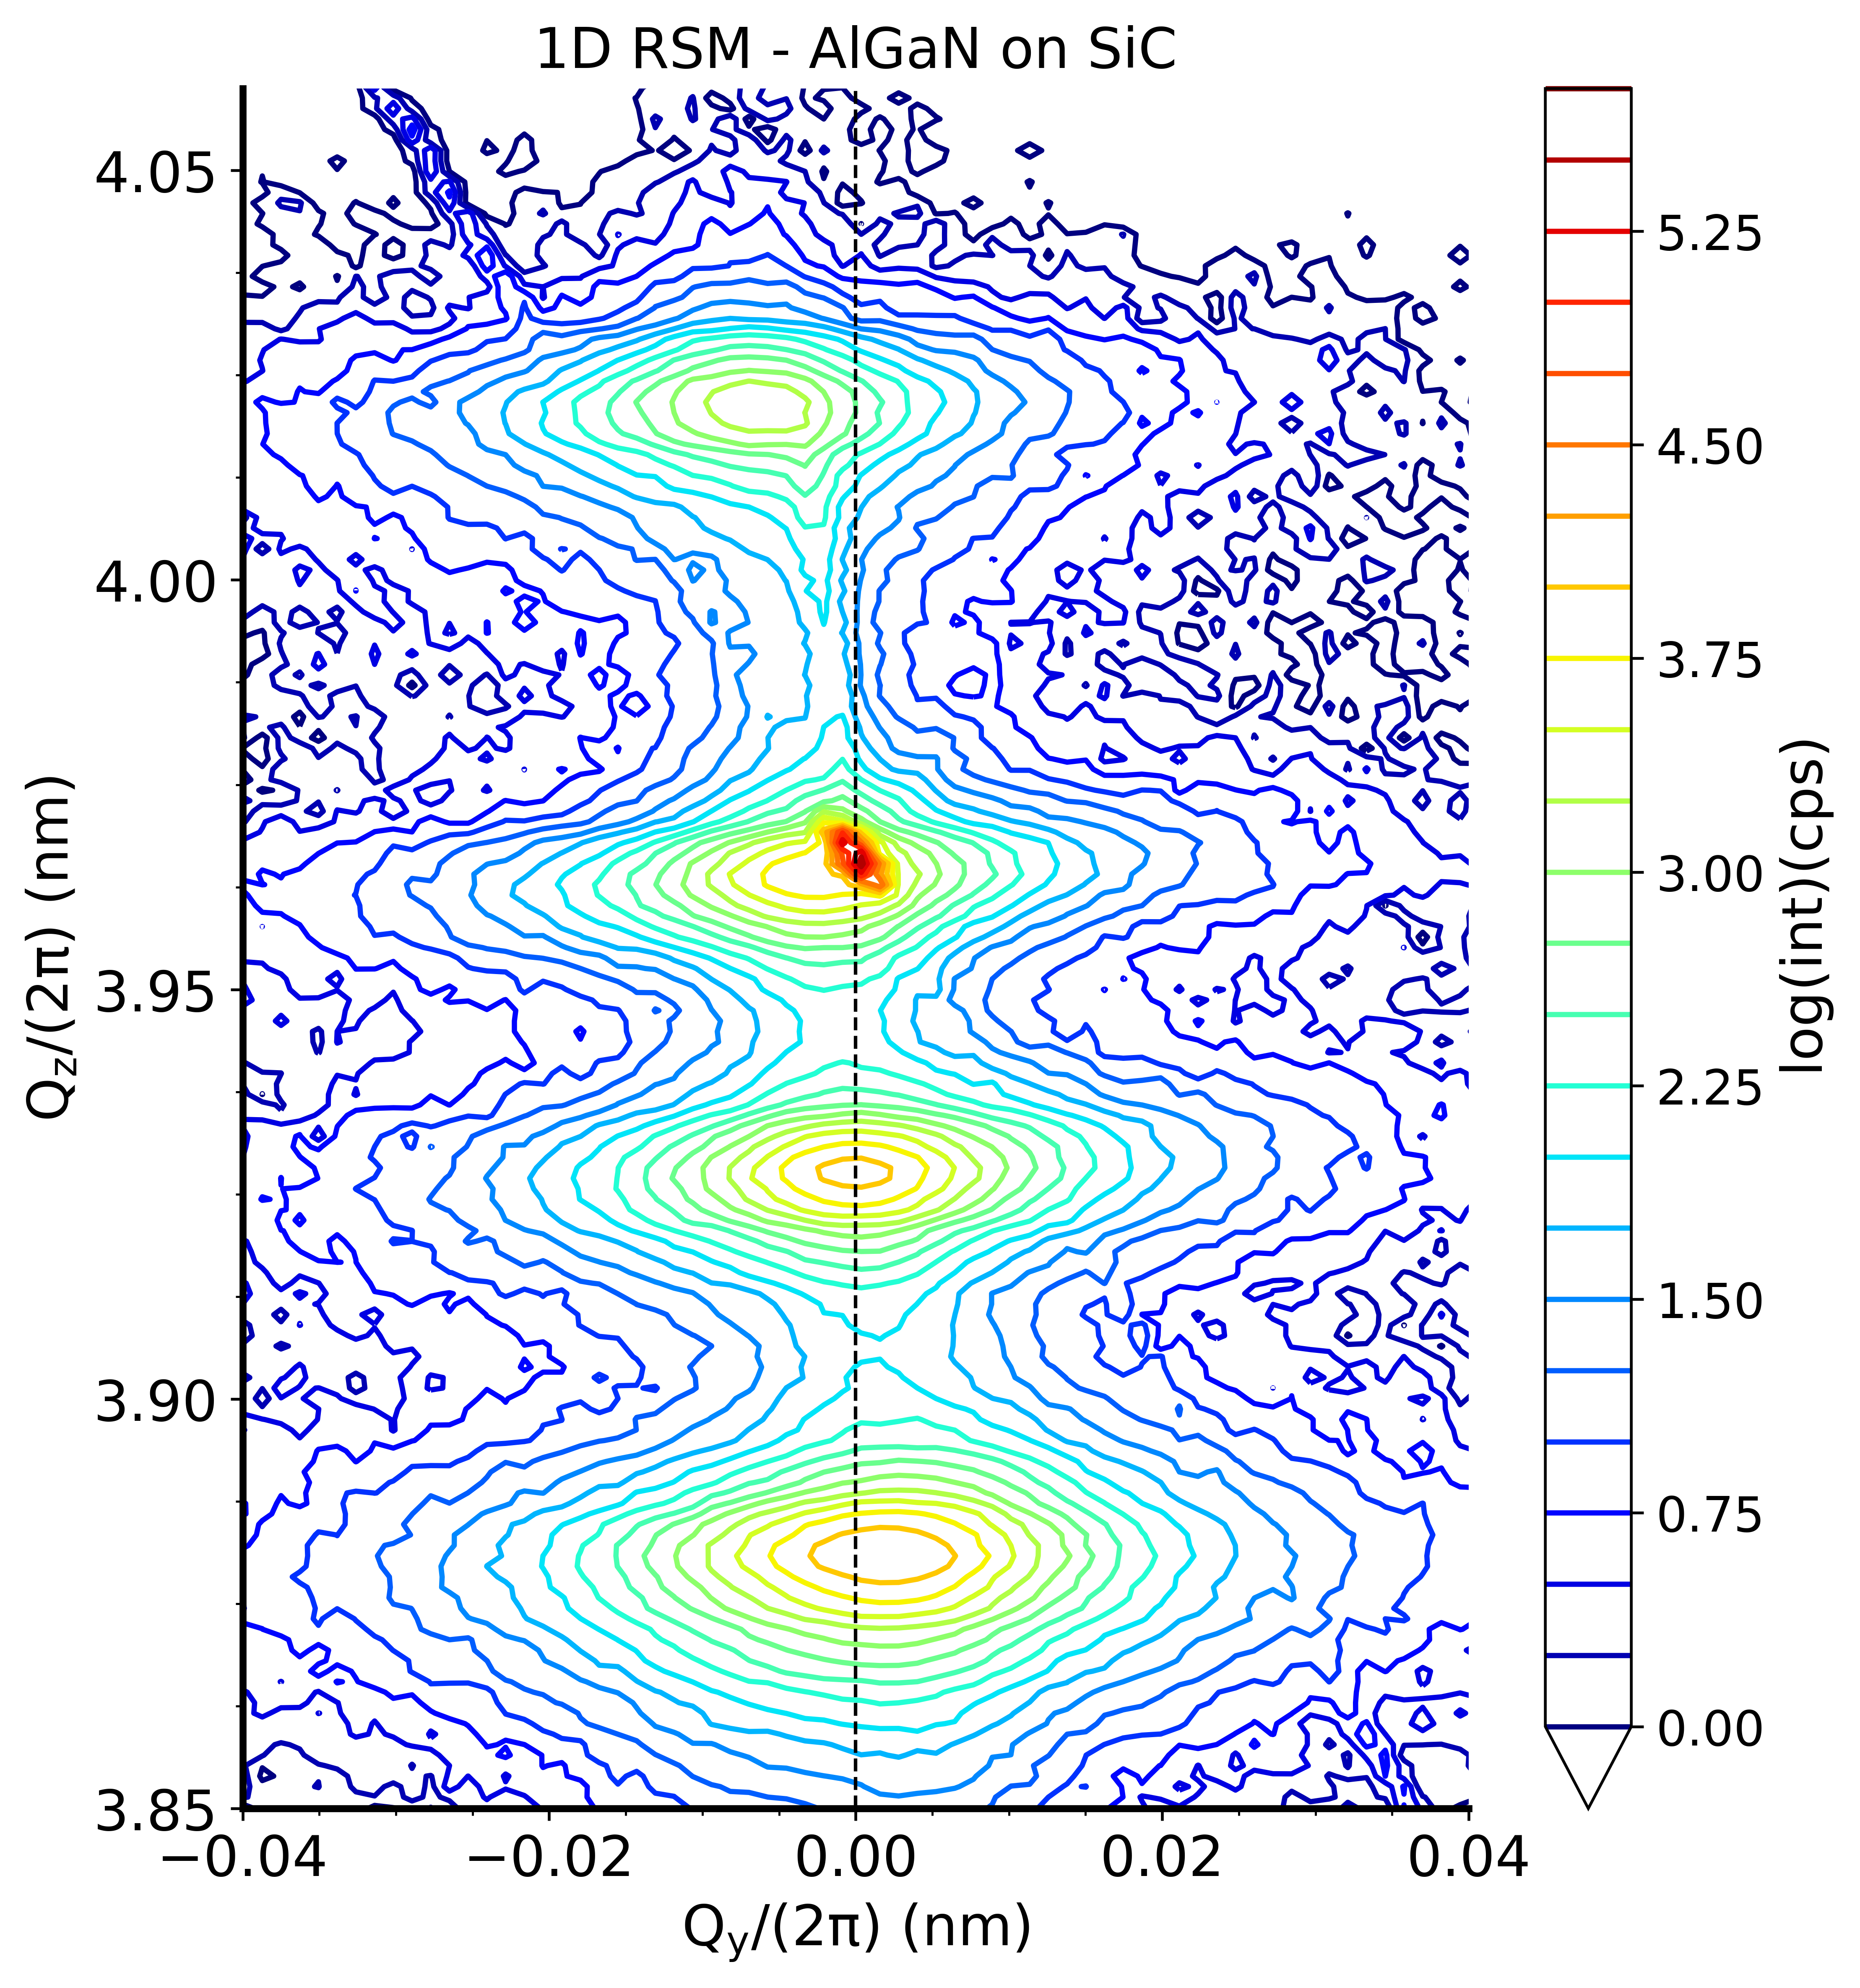

In [17]:
reciprocal_space_map_1D(
    ['../data/raw/20250528_M3-1146_RSM1D_SiC_0004.ras'],
    use_rlu = True, levels = 25, xlim = (-0.04, 0.04),
    ylim = (3.85, 4.06), grid_size = 256, dyn_low = 5.75, dyn_high = -1,
    label_size = 16, title = '1D RSM - AlGaN on SiC'
)